# Run Early vs. Late Universe case in PolyChord

This section sets up your hypotheses for the early vs. late Universe case in PolyChord.
Change bias flags for which hypotheses you want to look at. This is currently set up for early Universe being biased.

In [1]:
from numpy import pi, log
import pypolychord
from pypolychord.priors import UniformPrior
try:
    from mpi4py import MPI
except ImportError:
    pass
from chiborg import jk_data, jk_hyp, jk_calc, tm_prior
from chiborg.util import get_mut_info
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from more_itertools import powerset
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Load input data from Excel file
filename = '/home/quantom97/Documents/Dissertation Python Work/H0 measurements.xlsx'
my_data = pd.read_excel(filename, sheet_name='Independent points', nrows=16)

# User input: choose which bias terms are switched on. This will change depending on the Z>0.2 or Z.2 cut off.
# This is currently set-up for Z>2
bias_flags = [True, False]                                       # [early bias, late bias]
bias_one = [0, 1]                                                # indices for early data points
bias_two = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]      # indices for late data points

# Number of derived parameters
nDerived = 0

# Number of data points
nDat = len(my_data)

# Set dimensionality of parameter space depending on which biases are active
if bias_flags[0] and bias_flags[1]:
    nDims = 5
elif bias_flags[0] or bias_flags[1]:
    nDims = 3
else:
    nDims = 1

# Extract noise widths and H0 values
noise_column = my_data.iloc[:, 12]
noise_width = noise_column.to_numpy()
hubble_column = my_data.iloc[:, 6]
hubble_data = hubble_column.to_numpy()
noise_cov = np.diag(np.full(nDat, noise_width))  # diagonal noise covariance


def calculate_bias(params, bias_flags, nDat):
    """
    Calculate bias_mean and bias_cov matrices depending on which bias flags are active.
    
    Always keeps the null hypothesis (index 0) as zero mean and covariance.
    Updates the second entry of bias_mean and bias_cov if early and/or late biases are active.
    """
    # Always keep null hypothesis biases as zero
    bias_mean = [np.full(nDat, 0.0), np.full(nDat, 0.0)]
    bias_cov = [np.zeros((nDat, nDat)), np.zeros((nDat, nDat))]

    # Case: only early bias active
    if bias_flags[0]:
        for i in enumerate(bias_one):
            bias_mean[1][bias_one] = params[1]
            bias_cov[1][bias_one, bias_one] = params[2]

    # Case: only late bias active
    if bias_flags[1]:
        for i in enumerate(bias_two):
            bias_mean[1][bias_two] = params[1]
            bias_cov[1][bias_two, bias_two] = params[2]

    # Case: both early and late biases active
    if bias_flags[0] and bias_flags[1]:
        for i in enumerate(bias_one):
            bias_mean[1][bias_one] = params[1]
            bias_cov[1][bias_one, bias_one] = params[3]
        for i in enumerate(bias_two):
            bias_mean[1][bias_two] = params[2]
            bias_cov[1][bias_two, bias_two] = params[4]

    return bias_mean, bias_cov


def likelihood(params):
    """
    Chiborg likelihood function for H0 with optional bias terms.
    
    Unpacks parameters depending on dimensionality (1D, 3D, or 5D).
    Constructs bias means/covariances and evaluates the Gaussian log-likelihood
    using jk_data, jk_hyp, and jk_calc structures.
    """
    # Unpack parameters depending on dimensionality
    if nDims == 5:
        h0, early_bias_mean, late_bias_mean, early_bias_cov, late_bias_cov = params
    elif nDims == 3 and bias_flags[0] == True:
        h0, early_bias_mean, early_bias_cov = params
    elif nDims == 3 and bias_flags[1] == True:
        h0, late_bias_mean, late_bias_cov = params
    else:
        h0 = params

    # Build bias mean and covariance
    bias_mean, bias_cov = calculate_bias(params, bias_flags, nDat)

    # Prepare jackknife data object
    jkd = jk_data(
        meas_dat=hubble_data,
        noise_cov=noise_cov,
        simulate=False,
        num_draw=1,
        num_dat=nDat
    )

    # Prior on H0 (uniform in [50, 90])
    tmp = tm_prior(
        func=uniform.pdf,
        bounds=[60, 80],
        params={"loc": 60, "scale": 20},
        name="Gaussian"
    )

    # Construct hypothesis object with bias priors
    jkh = jk_hyp(
        jkd,
        bias_mean=bias_mean,
        bias_cov=bias_cov,
        tmp=tmp,
        hyp_prior=None,
        mode="manual"
    )

    # Calculator object for likelihood evaluation
    jkc = jk_calc(jkh, analytic=False, calc_on_init=False)

    # Extract modified covariance
    _, _, cov_sum = jkc._get_mod_var_cov_sum_inv(1)

    # Evaluate Gaussian likelihood
    gauss_1_arg = jkc.jk_hyp.jk_data.data_draws - jkc.jk_hyp.bias_prior.mean[1]
    gauss_1 = multivariate_normal.logpdf(
        gauss_1_arg,
        mean=np.full(jkc.jk_hyp.jk_data.num_dat, params[0]),
        cov=cov_sum
    )

    return gauss_1, None




In [ ]:
def prior(hypercube, mu=[60, 0], sigma=[20, 10, 20]):
    """
    Prior transformation function for parameter sampling.
    
    Maps a unit hypercube (values in [0, 1]) into physical parameter space 
    according to chosen prior distributions.
    
    - H0 is always drawn from a uniform distribution between 50 and 90.
    - Bias terms are drawn from Gaussian priors (mean 0, given sigma).
    - Bias covariance terms are drawn from uniform priors.
    
    Returns parameters depending on dimensionality:
        - 5D: [H0, early bias, late bias, early bias cov, late bias cov]
        - 3D (early bias only): [H0, early bias, early bias cov]
        - 3D (late bias only): [H0, late bias, late bias cov]
        - 1D: [H0] only
    """
    if nDims == 5:
        h0_prior = uniform.ppf(hypercube[0], loc=mu[0], scale=sigma[0])
        early_bias = norm.ppf(hypercube[1], loc=mu[1], scale=sigma[1])
        late_bias = norm.ppf(hypercube[2], loc=mu[1], scale=sigma[1])
        early_bias_cov = uniform.ppf(hypercube[3], loc=mu[1], scale=sigma[2])
        late_bias_cov = uniform.ppf(hypercube[4], loc=mu[1], scale=sigma[2])
        return h0_prior, early_bias, late_bias, early_bias_cov, late_bias_cov
    
    elif nDims == 3 and bias_flags[0] == True:
        h0_prior = uniform.ppf(hypercube[0], loc=mu[0], scale=sigma[0])
        early_bias = norm.ppf(hypercube[1], loc=mu[1], scale=sigma[1])
        early_bias_cov = uniform.ppf(hypercube[2], loc=mu[1], scale=sigma[2])
        return h0_prior, early_bias, early_bias_cov
    
    elif nDims == 3 and bias_flags[1] == True:
        h0_prior = uniform.ppf(hypercube[0], loc=mu[0], scale=sigma[0])
        late_bias = norm.ppf(hypercube[1], loc=mu[1], scale=sigma[1])
        late_bias_cov = uniform.ppf(hypercube[2], loc=mu[1], scale=sigma[2])
        return h0_prior, late_bias, late_bias_cov
    
    else:
        h0_prior = uniform.ppf(hypercube[0], loc=mu[0], scale=sigma[0])
        return h0_prior

In [ ]:
def dumper(live, dead, logweights, logZ, logZerr):
    """
    Utility function for nested sampling diagnostics.
    
    Prints the last "dead" point (the most recently removed sample) 
    during the sampling process.
    
    Parameters
    ----------
    live : list or array
        Current set of live points.
    dead : list or array
        Set of dead points (points already removed).
    logweights : array
        Logarithmic weights of the samples.
    logZ : float
        Current estimate of the log-evidence.
    logZerr : float
        Error estimate on the log-evidence.
    """
    print("Last dead point:", dead[-1])


In [ ]:
#! Define parameter names for output and plotting
#! Each entry is a tuple: (internal_label, LaTeX_label)
#! Derived parameters should be followed by a *

paramnames = [(f'p0', f'H_0')]  # Always include Hubble constant

# Add parameter names depending on dimensionality and active bias flags
if nDims == 5:
    # Both early- and late-universe biases active
    paramnames += [(f'p1', f'\\mu_{{\\varepsilon,early}}'), 
                   (f'p2', f'\\mu_{{\\varepsilon,late}}')]
    paramnames += [(f'p3', f'\\sigma_{{\\varepsilon,early}}^2'), 
                   (f'p4', f'\\sigma_{{\\varepsilon,late}}^2')]                   
elif nDims == 3 and bias_flags[0] == True:
    # Only early-universe bias active
    paramnames += [(f'p1', f'\\mu_{{\\varepsilon,early}}')]
    paramnames += [(f'p2', f'\\sigma_{{\\varepsilon,early}}^2')] 
elif nDims == 3 and bias_flags[1] == True:
    # Only late-universe bias active
    paramnames += [(f'p1', f'\\mu_{{\\varepsilon,late}}')]
    paramnames += [(f'p2', f'\\sigma_{{\\varepsilon,late}}^2')] 


In [6]:
output = pypolychord.run(
    likelihood,
    nDims,
    nDerived=nDerived,
    prior=prior,
    dumper=dumper,
    file_root='gaussian',
    nlive=300,
    num_repeats=nDims * 5,
    do_clustering=True,
    read_resume=False,
    paramnames=paramnames,
)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     300
nDims    :       3
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/gaussian.resume

generating live points


all live points generated

Speed  1 =  0.434E-01 seconds
number of repeats:           15
started sampling

Last dead point: [ 8.15392674e+01 -5.40626702e+00  1.98633397e+01 -1.00000000e+30
 -1.14951793e+02]
_________________
lives      | 300 |
phantoms   |2748 |
posteriors | 301 |
equals     |   4 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 301
nposterior =                 301
nequals    =                   6
nlike      =  

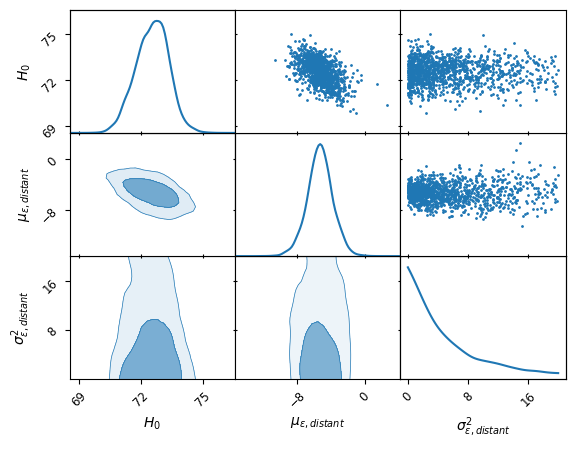

In [ ]:
try:
    from anesthetic import make_2d_axes, read_chains, Samples
    fig, ax = make_2d_axes(['p0', 'p1', 'p2'])
    output.plot_2d(ax)
    # chains_file = 'chains/gaussian'
    # samples = read_chains(chains_file)
    # samples.plot_2d(ax)
    fig.savefig('posterior.pdf')
except ImportError:
    print("Install anesthetic for plotting examples.")